# Typeform employee churn analysis and prediction

## Importing libraries and data

In [1]:
from scipy import stats

import numpy as np
import pandas as pd

import seaborn as sns
import cufflinks as cf
import plotly.express as px
from ipywidgets import interact
import matplotlib.pyplot as plt

In [2]:
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report, mean_squared_error
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.naive_bayes import GaussianNB, ComplementNB, MultinomialNB
from xgboost import XGBClassifier

In [3]:
plt.rcParams["figure.figsize"] = (10,6)

In [4]:
pd.options.plotting.backend = 'plotly'

In [5]:
df = pd.read_csv('project-public-clean.csv')

In [6]:
df.set_index('EEID', inplace=True)

In [7]:
df.head()

,Status,Age,Gender,Education Level,Hire Date,Termination Date,Termination Type,Termination Reason,Job Information: Date,Division,...,Supervisor EID,Pay rate,Pay rate - Currency code,Compensation Change Reason,Stock Options,Level,Is Supervisor,Length of service,Length of service: Years,Length of service: Months
EEID,,,,,,,,,,,,,,,,,,,,,
343,Inactive,28,Female,Undergraduate degree (Grado),2019-08-19,2019-09-30,Involuntary,End of contract,2019-08-19,People,...,1,6047.0,EUR,Reduce/Increase Working hours,N,Unknown,No,"1 month, 11 days",0,1
468,Inactive,29,Male,Unknown,2016-07-05,2017-03-30,Involuntary,End of contract,2016-07-05,Engineering,...,234,6144.0,EUR,Unknown,N,Unknown,No,"8 months, 25 days",0,8
458,Inactive,27,Male,Unknown,2016-09-05,2017-01-26,Involuntary,End of contract,2016-09-05,Engineering,...,0,6144.0,EUR,Unknown,N,Unknown,No,"4 months, 21 days",0,4
379,Inactive,25,Male,Undergraduate degree (Grado),2017-10-23,2018-08-28,Involuntary,End of contract,2017-10-23,Engineering,...,0,6144.0,EUR,New hire,N,Unknown,No,"10 months, 5 days",0,10
492,Inactive,58,Female,Unknown,2017-09-13,2017-09-29,Involuntary,End of contract,2017-09-13,People,...,0,7200.0,EUR,Unknown,N,Unknown,No,16 days,0,0


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 607 entries, 343 to 721
Data columns (total 21 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Status                      607 non-null    object 
 1   Age                         607 non-null    int64  
 2   Gender                      607 non-null    object 
 3   Education Level             607 non-null    object 
 4   Hire Date                   607 non-null    object 
 5   Termination Date            258 non-null    object 
 6   Termination Type            258 non-null    object 
 7   Termination Reason          254 non-null    object 
 8   Job Information: Date       607 non-null    object 
 9   Division                    607 non-null    object 
 10  Department                  607 non-null    object 
 11  Supervisor EID              607 non-null    int64  
 12  Pay rate                    607 non-null    float64
 13  Pay rate - Currency code    607 n

## Data wrangling

In [9]:
df['Attrition'] = pd.get_dummies(df['Termination Type'], drop_first=True)

In [10]:
df['Pay rate EUR'] = np.where(df['Pay rate - Currency code'] == 'USD', df['Pay rate'] * 0.82 * (1-0.38), df['Pay rate'])
# también funcionaría con lo siguiente, pero me queda mas claro usando np.where: df.apply(lambda x: (x['Pay rate'] * 0.82) if x['Pay rate - Currency code'] == 'USD' else x['Pay rate'], axis=1)

In [11]:
df['Pay rate EUR'] = np.where(df['Pay rate - Currency code'] == 'GBP', df['Pay rate'] * 1.16 * (1-0.41), df['Pay rate EUR'])

In [12]:
# Para comprobar que está bien:
df[['Pay rate', 'Pay rate - Currency code', 'Pay rate EUR']][df['Pay rate - Currency code'] == 'GBP']

,Pay rate,Pay rate - Currency code,Pay rate EUR
EEID,,,
700,41600.0,GBP,28471.04
697,44000.0,GBP,30113.60
779,44000.0,GBP,30113.60
698,56000.0,GBP,38326.40
774,68000.0,GBP,46539.20
757,68000.0,GBP,46539.20
731,96000.0,GBP,65702.40
161,99200.0,GBP,67892.48


In [13]:
# Location
df['Location'] = df.apply(lambda x: 'North America' if x['Pay rate - Currency code'] == 'USD' else 'Europe', axis=1)

In [14]:
# Reordenamos las columnas para que quede más claro:
df = df[['Status', 'Age', 'Gender', 'Education Level', 'Hire Date', 
       'Termination Date', 'Termination Type', 'Termination Reason', 'Attrition',
       'Job Information: Date', 'Location', 'Division', 'Department', 'Supervisor EID',
       'Pay rate', 'Pay rate - Currency code', 'Pay rate EUR', 'Compensation Change Reason',
       'Stock Options', 'Level', 'Is Supervisor', 'Length of service',
       'Length of service: Years', 'Length of service: Months']]

In [15]:
df['Age bracket'] = pd.cut(df['Age'], bins = [18, 25, 30, 35, 40, 45, 50, 55], labels = [i for i in range(7)])

In [16]:
df['Division'] = df['Division'].apply(lambda x: 'People & Home' if 'People' in x or 'Home' in x else x)

In [17]:
df['Division'] = df['Division'].apply(lambda x: 'Finance & Legal' if 'Finance' in x else x)

In [18]:
df['Division'] = df['Division'].apply(lambda x: 'Leadership' if 'Founders' in x else x)

In [19]:
df.groupby('Division').sum()['Attrition'] / df.groupby('Division').count()['Attrition']

Division
Business Development    0.294118
Customer Success        0.233766
Data & Analytics        0.228070
Design                  0.272727
Engineering             0.382775
Finance & Legal         0.272727
Leadership              0.333333
Marketing               0.327586
People & Home           0.272727
Product                 0.400000
R&D                     0.000000
Security                0.000000
Strategy                0.000000
Unknown                 0.333333
Name: Attrition, dtype: float64

In [20]:
df[df['Division'] == 'Unknown']

,Status,Age,Gender,Education Level,Hire Date,Termination Date,Termination Type,Termination Reason,Attrition,Job Information: Date,...,Pay rate - Currency code,Pay rate EUR,Compensation Change Reason,Stock Options,Level,Is Supervisor,Length of service,Length of service: Years,Length of service: Months,Age bracket
EEID,,,,,,,,,,,,,,,,,,,,,
428,Inactive,23,Female,Unknown,2018-07-02,2018-08-24,Involuntary,End of contract,0,2018-07-02,...,USD,12689.664,Unknown,N,L0,No,"1 month, 22 days",0,1,0
457,Inactive,25,Male,Unknown,2018-09-17,2018-12-17,Involuntary,End of contract,0,2018-09-17,...,USD,12689.664,Unknown,N,Unknown,No,"3 months, 0 days",0,3,0
427,Inactive,35,Female,Unknown,2016-07-18,2018-09-07,Voluntary,Other employment,1,2017-10-02,...,EUR,28248.000,Unknown,Y,Unknown,No,"2 years, 1 month, 20 days",2,26,2


In [21]:
df = pd.concat([df, pd.get_dummies(df['Gender'], drop_first=True)], axis=1)

In [22]:
df.drop(df.loc[df['Not Specified'] == 1].index, inplace=True)

In [23]:
df.drop(df.loc[df['Unknown'] == 1].index, inplace=True)

In [24]:
df = df.drop(columns=['Male', 'Not Specified', 'Unknown'])

In [25]:
df.drop('Education Level', axis=1, inplace=True)

In [26]:
df['North America'] = pd.get_dummies(df['Location'], drop_first=True)

In [27]:
df.Division.value_counts()

Engineering             207
Customer Success         76
Marketing                58
Data & Analytics         57
People & Home            54
Design                   44
Product                  40
Finance & Legal          22
Business Development     17
Strategy                 11
Security                  8
R&D                       3
Unknown                   3
Leadership                3
Name: Division, dtype: int64

In [28]:
df['Has_stock'] = pd.get_dummies(df['Stock Options'], drop_first=True)

In [29]:
df['Level'].value_counts()
# muchos valores unknown!

E3         157
E2         135
Unknown     68
M1          44
L2          43
L3          30
M3          28
M2          21
E4          20
E1          20
L1           7
C-Level      7
E0           6
M4           5
L4           5
L0           2
E5           2
M0           1
L5           1
E6           1
Name: Level, dtype: int64

In [30]:
df['Level'] = df['Level'].replace('(.*)[^EM](?=\d)','E', regex=True)

In [31]:
df['Level'] = df['Level'].replace('M0', 'M1')

In [32]:
df.head()

,Status,Age,Gender,Hire Date,Termination Date,Termination Type,Termination Reason,Attrition,Job Information: Date,Location,...,Compensation Change Reason,Stock Options,Level,Is Supervisor,Length of service,Length of service: Years,Length of service: Months,Age bracket,North America,Has_stock
EEID,,,,,,,,,,,,,,,,,,,,,
343,Inactive,28,Female,2019-08-19,2019-09-30,Involuntary,End of contract,0,2019-08-19,Europe,...,Reduce/Increase Working hours,N,Unknown,No,"1 month, 11 days",0,1,1,0,0
468,Inactive,29,Male,2016-07-05,2017-03-30,Involuntary,End of contract,0,2016-07-05,Europe,...,Unknown,N,Unknown,No,"8 months, 25 days",0,8,1,0,0
458,Inactive,27,Male,2016-09-05,2017-01-26,Involuntary,End of contract,0,2016-09-05,Europe,...,Unknown,N,Unknown,No,"4 months, 21 days",0,4,1,0,0
379,Inactive,25,Male,2017-10-23,2018-08-28,Involuntary,End of contract,0,2017-10-23,Europe,...,New hire,N,Unknown,No,"10 months, 5 days",0,10,0,0,0
492,Inactive,58,Female,2017-09-13,2017-09-29,Involuntary,End of contract,0,2017-09-13,Europe,...,Unknown,N,Unknown,No,16 days,0,0,NaN,0,0


In [33]:
df.columns

Index(['Status', 'Age', 'Gender', 'Hire Date', 'Termination Date',
       'Termination Type', 'Termination Reason', 'Attrition',
       'Job Information: Date', 'Location', 'Division', 'Department',
       'Supervisor EID', 'Pay rate', 'Pay rate - Currency code',
       'Pay rate EUR', 'Compensation Change Reason', 'Stock Options', 'Level',
       'Is Supervisor', 'Length of service', 'Length of service: Years',
       'Length of service: Months', 'Age bracket', 'North America',
       'Has_stock'],
      dtype='object')

In [34]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 603 entries, 343 to 721
Data columns (total 26 columns):
 #   Column                      Non-Null Count  Dtype   
---  ------                      --------------  -----   
 0   Status                      603 non-null    object  
 1   Age                         603 non-null    int64   
 2   Gender                      603 non-null    object  
 3   Hire Date                   603 non-null    object  
 4   Termination Date            256 non-null    object  
 5   Termination Type            256 non-null    object  
 6   Termination Reason          252 non-null    object  
 7   Attrition                   603 non-null    uint8   
 8   Job Information: Date       603 non-null    object  
 9   Location                    603 non-null    object  
 10  Division                    603 non-null    object  
 11  Department                  603 non-null    object  
 12  Supervisor EID              603 non-null    int64   
 13  Pay rate          

In [35]:
cols_to_drop = ['Hire Date', 'Termination Date', 'Termination Type', 'Termination Reason', 'Job Information: Date',
                'Department', 'Supervisor EID', 'Pay rate', 'Pay rate - Currency code','Compensation Change Reason', 'Length of service', 
                'Length of service: Years', 'Age bracket', 'Is Supervisor']
# borro las columnas que no vamos a usar

In [36]:
df.drop(cols_to_drop, axis=1, inplace=True)

In [37]:
df.head()

,Status,Age,Gender,Attrition,Location,Division,Pay rate EUR,Stock Options,Level,Length of service: Months,North America,Has_stock
EEID,,,,,,,,,,,,
343,Inactive,28,Female,0,Europe,People & Home,6047.0,N,Unknown,1,0,0
468,Inactive,29,Male,0,Europe,Engineering,6144.0,N,Unknown,8,0,0
458,Inactive,27,Male,0,Europe,Engineering,6144.0,N,Unknown,4,0,0
379,Inactive,25,Male,0,Europe,Engineering,6144.0,N,Unknown,10,0,0
492,Inactive,58,Female,0,Europe,People & Home,7200.0,N,Unknown,0,0,0


## Exploratory Data Analysis (Shapiro tests, plots)

Variable que queremos predecir: **Attrition**

Variables que nos interesan: 

**Numéricas:**
- Age
- Pay rate EUR
- Lenghts of service (months)

**Categóricas:**
- Gender
- Location
- Division
- Stock Options
- Is Supervisor
- Age bracket

**Columnas encoded**: 'Female', 'North America', 'Business Development', 'Customer Success',
       'Data & Analytics', 'Design', 'Engineering', 'Finance & Legal',
       'Leadership', 'Marketing', 'People & Home', 'Product', 'R&D',
       'Security', 'Strategy', 'Has_stock', 'C-Level', 'E0', 'E1', 'E2', 'E3',
       'E4', 'E5', 'E6', 'L0', 'L1', 'L2', 'L3', 'L4', 'L5', 'M0', 'M1', 'M2',
       'M3', 'M4', 'Unknown_level', 'Is_Supervisor_enc'


### Numerical variables

In [38]:
stats.shapiro(df['Age'])

ShapiroResult(statistic=0.9524832963943481, pvalue=5.08773687242503e-13)

In [39]:
df['Age'].iplot('hist')

In [40]:
stats.shapiro(df['Pay rate EUR'])

ShapiroResult(statistic=0.8029524683952332, pvalue=1.9286060625635608e-26)

In [41]:
df['Pay rate EUR'].iplot('hist')

In [42]:
stats.shapiro(df['Length of service: Months'])

ShapiroResult(statistic=0.8911247253417969, pvalue=3.185232462693613e-20)

In [43]:
df['Length of service: Months'].iplot('hist')

## Categorical variables

In [44]:
colors = ['red', 'blue']

In [45]:
px.bar(df['Gender'].value_counts(), color=colors, color_discrete_map="identity")

In [46]:
px.bar(df['Location'].value_counts(), color=colors, color_discrete_map="identity")

In [47]:
px.bar(df['Division'].value_counts(), color=df['Division'].value_counts(), color_discrete_map="identity")

In [48]:
px.bar(df['Stock Options'].value_counts(), color=colors, color_discrete_map="identity")

In [49]:
px.bar(df['Level'].value_counts(), color=df['Level'].value_counts())

# Hypothesis testing (Mann Whitney Test, Chi2)

## Continuous variables - Mann Whitney Test

In [50]:
not_attrition = df[df['Attrition'] == 0]
attrition = df[df['Attrition'] == 1]

### Pay rate

In [51]:
stats.mannwhitneyu(not_attrition['Pay rate EUR'], attrition['Pay rate EUR'])
# aceptamos la H0, no hay diferencia de medias significativa en el salario

MannwhitneyuResult(statistic=36708.0, pvalue=0.1470652209107165)

In [52]:
df[['Attrition', 'Pay rate EUR']].pivot(columns='Attrition', values='Pay rate EUR').iplot(kind='box')

In [53]:
q25 = df['Pay rate EUR'].describe()[4]
q75 = df['Pay rate EUR'].describe()[6]

In [54]:
iqr = q75 - q25
iqr

20600.0

In [55]:
cut_off = iqr * 1.5

In [56]:
lower, upper = q25 - cut_off, q75 + cut_off
lower, upper

(1100.0, 83500.0)

In [57]:
not_outliers = [x for x in df['Pay rate EUR'] if x > lower and x < upper]

In [58]:
df = df[df['Pay rate EUR'].isin(not_outliers)]

In [59]:
df.shape

(573, 12)

### Age

In [60]:
stats.mannwhitneyu(not_attrition['Age'], attrition['Age'])
# aceptamos la H0, no hay diferencia de medias significativa en la edad

MannwhitneyuResult(statistic=38483.0, pvalue=0.44005710982192214)

In [61]:
q25 = df['Age'].describe()[4]
q75 = df['Age'].describe()[6]

In [62]:
iqr = q75 - q25
iqr

7.0

In [63]:
cut_off = iqr * 1.5

In [64]:
lower, upper = q25 - cut_off, q75 + cut_off
lower, upper

(19.5, 47.5)

In [65]:
not_outliers = [x for x in df['Age'] if x > lower and x < upper]

In [66]:
df = df[df['Age'].isin(not_outliers)]

In [67]:
df.shape

(562, 12)

### Length of service

In [68]:
stats.mannwhitneyu(not_attrition['Length of service: Months'], attrition['Length of service: Months'])

MannwhitneyuResult(statistic=24907.0, pvalue=1.0770431451273054e-12)

In [69]:
df[['Attrition', 'Length of service: Months']].pivot(columns='Attrition', values='Length of service: Months').iplot(kind='box')

In [70]:
q25 = df['Length of service: Months'].describe()[4]
q75 = df['Length of service: Months'].describe()[6]

In [71]:
iqr = q75 - q25
iqr

21.0

In [72]:
cut_off = iqr * 1.5
cut_off

31.5

In [73]:
upper = q75 + cut_off
upper

61.5

In [74]:
not_outliers = [x for x in df['Length of service: Months'] if x < upper]

In [75]:
df = df[df['Length of service: Months'].isin(not_outliers)]

In [76]:
df.shape

(544, 12)

## Discrete variables - Chi2

### Gender

In [77]:
df_gender = pd.DataFrame(df.groupby('Gender').sum()['Attrition'])

In [78]:
df_gender['Not_Attrition'] = df.groupby('Gender').count()['Attrition'] - df_gender['Attrition']
df_gender

,Attrition,Not_Attrition
Gender,,
Female,61,125
Male,110,248


In [79]:
stats.chi2_contingency(df_gender)
# el p-value está muy por encima de 0.05, así que no hay diferencia entre la media de attrition por géneros. 

(0.1566780798896903,
 0.6922335275371927,
 1,
 array([[ 58.46691176, 127.53308824],
        [112.53308824, 245.46691176]]))

### Location

In [80]:
df_location = pd.DataFrame(df.groupby('Location').sum()['Attrition'])

In [81]:
df_location['Not_Attrition'] = df.groupby('Location').count()['Attrition'] - df_location['Attrition']
df_location

,Attrition,Not_Attrition
Location,,
Europe,161,331
North America,10,42


In [82]:
stats.chi2_contingency(df_location)
# el p-value está muy por encima de 0.05, así que no hay diferencia entre la media de attrition por ubicaciones. 

(3.371162994933071,
 0.06634690384046787,
 1,
 array([[154.65441176, 337.34558824],
        [ 16.34558824,  35.65441176]]))

### Division

In [83]:
df_division = pd.DataFrame(df.groupby('Division').sum()['Attrition'])

In [84]:
df_division['Not_Attrition'] = df.groupby('Division').count()['Attrition'] - df_division['Attrition']

In [85]:
df_division

,Attrition,Not_Attrition
Division,,
Business Development,4,12
Customer Success,16,53
Data & Analytics,13,40
Design,12,29
Engineering,73,119
Finance & Legal,5,13
Marketing,17,34
People & Home,15,35
Product,15,18


In [86]:
stats.chi2_contingency(df_division)
# p-value un poco por debajo de 0.05. 
# Rechazamos la H0 y concluimos que si hay una diferencia significativa en attrition por divisiones

(19.12246862201847,
 0.08561547921702146,
 12,
 array([[  5.02941176,  10.97058824],
        [ 21.68933824,  47.31066176],
        [ 16.65992647,  36.34007353],
        [ 12.88786765,  28.11213235],
        [ 60.35294118, 131.64705882],
        [  5.65808824,  12.34191176],
        [ 16.03125   ,  34.96875   ],
        [ 15.71691176,  34.28308824],
        [ 10.37316176,  22.62683824],
        [  0.31433824,   0.68566176],
        [  2.20036765,   4.79963235],
        [  3.14338235,   6.85661765],
        [  0.94301471,   2.05698529]]))

In [87]:
df_division['Proportion'] = df_division['Attrition'] / (df_division['Attrition'] + df_division['Not_Attrition'])

In [88]:
px.bar(df_division, x=df_division.index, y='Proportion', color='Proportion').update_xaxes(categoryorder='total descending')
# product y Engineering son las divsiones con más attrition y Strategy, Security y R&D las que tienen menos

### Stock options

In [89]:
df_stock = pd.DataFrame(df.groupby('Stock Options').sum()['Attrition'])

In [90]:
df_stock['Not_Attrition'] = df.groupby('Stock Options').count()['Attrition'] - df_stock['Attrition']
df_stock

,Attrition,Not_Attrition
Stock Options,,
N,30.0,248.0
Y,141.0,125.0


In [91]:
stats.chi2_contingency(df_stock)
# el p-value está muy por debajo de 0.05, así que sí que hay diferencia entre la media de attrition según si los empleados 
# tienen acciones o no. 

(110.45275868558906,
 7.798180530136273e-26,
 1,
 array([[ 87.38602941, 190.61397059],
        [ 83.61397059, 182.38602941]]))

In [92]:
df_stock['Proportion'] = df_stock['Attrition'] / (df_stock['Attrition'] + df_stock['Not_Attrition'])

In [93]:
px.bar(df_stock, x=df_stock.index, y='Proportion', color='Proportion').update_xaxes(categoryorder='total descending')
# vemos que los empleados que tienen acciones tienen más tendencia a irse. 
# esto no es cierto, lo que pasa en realidad es que los primeros empleados recibieron stock 
# y la mayoría ya se han ido, pero el stock no es la causa. 
# Eliminamos esta variable del df para que no introduzca ruido. 

In [94]:
df.drop(columns=['Has_stock','Stock Options'], inplace=True)

### Level

In [95]:
df_level = pd.DataFrame(df.groupby('Level').sum()['Attrition'])

In [96]:
df_level['Not_Attrition'] = df.groupby('Level').count()['Attrition'] - df_level['Attrition']
df_level

,Attrition,Not_Attrition
Level,,
E0,0,8
E1,10,16
E2,52,120
E3,44,133
E4,4,18
E5,1,2
E6,0,1
M1,20,22
M2,4,13


In [97]:
stats.chi2_contingency(df_level)
# el p-value está muy por debajo de 0.05, así que sí que hay diferencia entre la media de attrition según el nivel.

(28.935896759560215,
 0.0012761671127270032,
 10,
 array([[  2.51470588,   5.48529412],
        [  8.17279412,  17.82720588],
        [ 54.06617647, 117.93382353],
        [ 55.63786765, 121.36213235],
        [  6.91544118,  15.08455882],
        [  0.94301471,   2.05698529],
        [  0.31433824,   0.68566176],
        [ 13.20220588,  28.79779412],
        [  5.34375   ,  11.65625   ],
        [  5.65808824,  12.34191176],
        [ 18.23161765,  39.76838235]]))

In [98]:
df_level['Proportion'] = df_level['Attrition'] / (df_level['Attrition'] + df_level['Not_Attrition'])

In [99]:
px.bar(df_level, x=df_level.index, y='Proportion', color='Proportion').update_xaxes(categoryorder='total descending')
# vemos que los empleados con nivel Unknown se han ido en mayor proporción. 
# M1 (middle management) y E1 (empleados más junior) son los que más attrition tienen. 
# Los Managers y empleados de mayor nivel, los interns y el C-Level son los que menos attrition tienen. 

# Preprocessing

## Creating new features

### Level by attrition proportion

In [100]:
level_dict = df.groupby('Level')['Attrition'].mean().to_dict()

In [101]:
level_dict['Unknown'] = df['Attrition'].mean()

In [102]:
level_dict

{'E0': 0.0,
 'E1': 0.38461538461538464,
 'E2': 0.3023255813953488,
 'E3': 0.24858757062146894,
 'E4': 0.18181818181818182,
 'E5': 0.3333333333333333,
 'E6': 0.0,
 'M1': 0.47619047619047616,
 'M2': 0.23529411764705882,
 'M3': 0.2777777777777778,
 'Unknown': 0.31433823529411764}

In [103]:
df['Level_attrition_proportion'] = df['Level'].map(level_dict)

### Division by attrition proportion

In [104]:
division_dict = df.groupby('Division')['Attrition'].mean().to_dict()
division_dict

{'Business Development': 0.25,
 'Customer Success': 0.2318840579710145,
 'Data & Analytics': 0.24528301886792453,
 'Design': 0.2926829268292683,
 'Engineering': 0.3802083333333333,
 'Finance & Legal': 0.2777777777777778,
 'Marketing': 0.3333333333333333,
 'People & Home': 0.3,
 'Product': 0.45454545454545453,
 'R&D': 0.0,
 'Security': 0.0,
 'Strategy': 0.0,
 'Unknown': 0.3333333333333333}

In [105]:
level_dict['Unknown'] = df['Attrition'].mean()

In [106]:
df['Division_attrition_proportion'] = df['Division'].map(division_dict)
df['Division_attrition_proportion']

EEID
343    0.300000
468    0.380208
458    0.380208
379    0.380208
570    0.000000
         ...   
515    0.380208
554    0.380208
576    0.454545
281    0.454545
763    0.333333
Name: Division_attrition_proportion, Length: 544, dtype: float64

### Salary difference with mean of the same level in the same division

In [107]:
mean_division_level_salary = df.groupby(['Division', 'Level'])['Pay rate EUR'].agg(['mean']).reset_index().rename(columns={'mean' : 'Mean Pay rate EUR'})
mean_division_level_salary

,Division,Level,Mean Pay rate EUR
0,Business Development,E1,25200.000000
1,Business Development,E2,23996.480000
2,Business Development,E3,34733.080000
3,Business Development,E4,40672.000000
4,Business Development,M1,36800.000000
...,...,...,...
82,Strategy,E2,32000.000000
83,Strategy,E3,45708.666667
84,Strategy,E4,77600.000000
85,Unknown,E0,12689.664000


In [108]:
df = df.reset_index().merge(mean_division_level_salary, on=['Division', 'Level']).set_index('EEID')
df

,Status,Age,Gender,Attrition,Location,Division,Pay rate EUR,Level,Length of service: Months,North America,Level_attrition_proportion,Division_attrition_proportion,Mean Pay rate EUR
EEID,,,,,,,,,,,,,
343,Inactive,28,Female,0,Europe,People & Home,6047.00,Unknown,1,0,0.314338,0.300000,26527.916667
483,Inactive,31,Female,0,Europe,People & Home,12288.00,Unknown,5,0,0.314338,0.300000,26527.916667
488,Inactive,33,Female,0,Europe,People & Home,19200.00,Unknown,9,0,0.314338,0.300000,26527.916667
489,Inactive,34,Female,1,Europe,People & Home,19200.00,Unknown,15,0,0.314338,0.300000,26527.916667
359,Inactive,41,Female,0,Europe,People & Home,19200.00,Unknown,7,0,0.314338,0.300000,26527.916667
...,...,...,...,...,...,...,...,...,...,...,...,...,...
737,Active,33,Female,0,North America,Business Development,40672.00,E4,2,1,0.181818,0.250000,40672.000000
161,Active,44,Male,0,Europe,R&D,67892.48,E6,19,0,0.000000,0.000000,67892.480000
579,Active,45,Male,0,North America,Business Development,61008.00,M3,13,1,0.277778,0.250000,61008.000000


In [109]:
df['Pay_rate_diff'] = df['Pay rate EUR'] - df['Mean Pay rate EUR']

In [110]:
df.drop('Mean Pay rate EUR', axis=1, inplace=True)

In [111]:
df.head()

,Status,Age,Gender,Attrition,Location,Division,Pay rate EUR,Level,Length of service: Months,North America,Level_attrition_proportion,Division_attrition_proportion,Pay_rate_diff
EEID,,,,,,,,,,,,,
343,Inactive,28,Female,0,Europe,People & Home,6047.0,Unknown,1,0,0.314338,0.3,-20480.916667
483,Inactive,31,Female,0,Europe,People & Home,12288.0,Unknown,5,0,0.314338,0.3,-14239.916667
488,Inactive,33,Female,0,Europe,People & Home,19200.0,Unknown,9,0,0.314338,0.3,-7327.916667
489,Inactive,34,Female,1,Europe,People & Home,19200.0,Unknown,15,0,0.314338,0.3,-7327.916667
359,Inactive,41,Female,0,Europe,People & Home,19200.0,Unknown,7,0,0.314338,0.3,-7327.916667


## Dimensionality reduction

In [112]:
# sacar csv con solo las numéricas

In [113]:
df_num = df.select_dtypes('number')
df_num

,Age,Attrition,Pay rate EUR,Length of service: Months,North America,Level_attrition_proportion,Division_attrition_proportion,Pay_rate_diff
EEID,,,,,,,,
343,28,0,6047.00,1,0,0.314338,0.300000,-20480.916667
483,31,0,12288.00,5,0,0.314338,0.300000,-14239.916667
488,33,0,19200.00,9,0,0.314338,0.300000,-7327.916667
489,34,1,19200.00,15,0,0.314338,0.300000,-7327.916667
359,41,0,19200.00,7,0,0.314338,0.300000,-7327.916667
...,...,...,...,...,...,...,...,...
737,33,0,40672.00,2,1,0.181818,0.250000,0.000000
161,44,0,67892.48,19,0,0.000000,0.000000,0.000000
579,45,0,61008.00,13,1,0.277778,0.250000,0.000000


In [114]:
df_num.columns.values

array(['Age', 'Attrition', 'Pay rate EUR', 'Length of service: Months',
       'North America', 'Level_attrition_proportion',
       'Division_attrition_proportion', 'Pay_rate_diff'], dtype=object)

In [115]:
reordered = ['Attrition', 'Age', 'Pay rate EUR',
       'Length of service: Months', 'North America',
       'Level_attrition_proportion', 'Division_attrition_proportion',
       'Pay_rate_diff']

In [116]:
df_num = df_num[reordered]

In [117]:
df_num.to_csv('typeform-encoded.csv')

See the other notebook

## Feature selection - Looking for collinearity

In the statistical analysis we have seen that the variables that have a significant influence on the mean attrition are: 'Length of service: Months', 'Division', 'Stock Options', 'Level'. 

In [118]:
#plt.rcParams["figure.figsize"] = (15,12)

<AxesSubplot:>

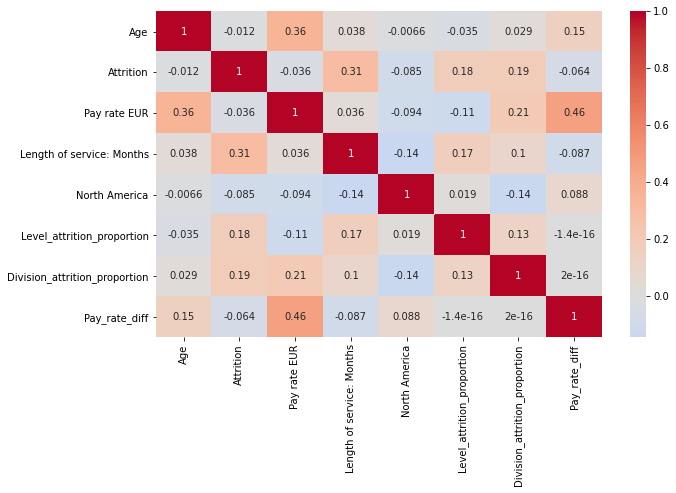

In [119]:
sns.heatmap(data=df.corr(), cmap='coolwarm', center=0, annot=True)

## Scaling

In [120]:
sc = StandardScaler()

In [121]:
data_scaled = sc.fit_transform(df_num.drop('Attrition', axis=1))
data_scaled

array([[-1.08709891e+00, -2.34168476e+00, -1.23211348e+00, ...,
         3.09630929e-01, -1.64728826e-01, -2.92075138e+00],
       [-5.11264630e-01, -1.93184965e+00, -9.61543397e-01, ...,
         3.09630929e-01, -1.64728826e-01, -2.03073217e+00],
       [-1.27375108e-01, -1.47795118e+00, -6.90973317e-01, ...,
         3.09630929e-01, -1.64728826e-01, -1.04502270e+00],
       ...,
       [ 2.17596202e+00,  1.26750413e+00, -4.20403236e-01, ...,
        -1.72670977e-01, -7.39167808e-01, -1.49729067e-16],
       [ 2.17596202e+00,  1.26750413e+00, -4.88045756e-01, ...,
        -7.33111181e-01, -7.39167808e-01, -1.49729067e-16],
       [ 1.02429346e+00,  2.46938945e+00,  7.29519606e-01, ...,
         5.60212366e-01,  1.61080985e+00, -1.49729067e-16]])

In [122]:
X = data_scaled
y = df_num['Attrition']

# Model testing

Note about confusion matrix: A perfect classifier would have only true positives and true negatives, so its confusion matrix would have nonzero values only on its main diagonal (top left to bottom right). Example trying to predict 5 (positive, 1) vs other numbers (negative, 0)

![abc](Captura.PNG)

## LogisticRegression, RandomForest, SVM, VotingClassifier

In [123]:
data_scaled = sc.fit_transform(df_num.drop('Attrition', axis=1))

In [124]:
X = data_scaled
y = df_num['Attrition']

In [125]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [126]:
log_clf = LogisticRegression()
rnd_clf = RandomForestClassifier()
svm_clf = SVC()

In [127]:
voting_clf = VotingClassifier(
    estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
    voting='hard')

In [128]:
for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred), '\n', confusion_matrix(y_pred, y_test), '\n', classification_report(y_pred, y_test))

LogisticRegression 0.8165137614678899 
 [[79 14]
 [ 6 10]] 
               precision    recall  f1-score   support

           0       0.93      0.85      0.89        93
           1       0.42      0.62      0.50        16

    accuracy                           0.82       109
   macro avg       0.67      0.74      0.69       109
weighted avg       0.85      0.82      0.83       109

RandomForestClassifier 0.7522935779816514 
 [[72 14]
 [13 10]] 
               precision    recall  f1-score   support

           0       0.85      0.84      0.84        86
           1       0.42      0.43      0.43        23

    accuracy                           0.75       109
   macro avg       0.63      0.64      0.63       109
weighted avg       0.76      0.75      0.75       109

SVC 0.7889908256880734 
 [[79 17]
 [ 6  7]] 
               precision    recall  f1-score   support

           0       0.93      0.82      0.87        96
           1       0.29      0.54      0.38        13

    accura

In [129]:
print(classification_report(y_pred, y_test))

              precision    recall  f1-score   support

           0       0.95      0.83      0.89        98
           1       0.29      0.64      0.40        11

    accuracy                           0.81       109
   macro avg       0.62      0.73      0.64       109
weighted avg       0.89      0.81      0.84       109



## Naive Bayes

In [130]:
X = df_num.drop(columns=['Attrition', 'Pay_rate_diff'], axis=1)
y = df_num['Attrition']

In [131]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [132]:
cnb = ComplementNB()
mnb = MultinomialNB()
gnb = GaussianNB()

In [133]:
for clf in (gnb, cnb, mnb):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred), '\n', confusion_matrix(y_pred, y_test), '\n',
          classification_report(y_pred, y_test))

GaussianNB 0.7889908256880734 
 [[78 16]
 [ 7  8]] 
               precision    recall  f1-score   support

           0       0.92      0.83      0.87        94
           1       0.33      0.53      0.41        15

    accuracy                           0.79       109
   macro avg       0.63      0.68      0.64       109
weighted avg       0.84      0.79      0.81       109

ComplementNB 0.6422018348623854 
 [[56 10]
 [29 14]] 
               precision    recall  f1-score   support

           0       0.66      0.85      0.74        66
           1       0.58      0.33      0.42        43

    accuracy                           0.64       109
   macro avg       0.62      0.59      0.58       109
weighted avg       0.63      0.64      0.61       109

MultinomialNB 0.6880733944954128 
 [[62 11]
 [23 13]] 
               precision    recall  f1-score   support

           0       0.73      0.85      0.78        73
           1       0.54      0.36      0.43        36

    accuracy      

## xgboost

In [134]:
data_scaled = sc.fit_transform(df_num.drop('Attrition', axis=1))

In [135]:
X = data_scaled
y = df_num['Attrition']

In [136]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)

In [137]:
from xgboost import XGBClassifier

xgb = XGBClassifier(
      max_depth=2,
      gamma=2,
      eta=0.8,
      reg_alpha=0.5,
      reg_lambda=0.5)

In [138]:
xgb.fit(X_train, y_train)
y_pred = xgb.predict(X_test)
print(xgb.__class__.__name__, accuracy_score(y_test, y_pred), '\n', confusion_matrix(y_pred, y_test), '\n', classification_report(y_pred, y_test))

[21:14:51] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
XGBClassifier 0.7022058823529411 
 [[161  52]
 [ 29  30]] 
               precision    recall  f1-score   support

           0       0.85      0.76      0.80       213
           1       0.37      0.51      0.43        59

    accuracy                           0.70       272
   macro avg       0.61      0.63      0.61       272
weighted avg       0.74      0.70      0.72       272



c:\users\júlia\appdata\local\programs\python\python39\lib\site-packages\xgboost\sklearn.py:1146: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].



# Final model - Support Vector Machine (SVM)

In [139]:
random_df = df.sample(frac=1)

In [140]:
df_num = random_df.select_dtypes('number')
df_num

,Age,Attrition,Pay rate EUR,Length of service: Months,North America,Level_attrition_proportion,Division_attrition_proportion,Pay_rate_diff
EEID,,,,,,,,
679,32,0,68000.0,4,0,0.248588,0.454545,-1416.914286
424,33,1,36800.0,30,0,0.302326,0.292683,5506.076923
326,32,1,33600.0,32,0,0.302326,0.333333,412.250000
365,28,1,38240.0,15,0,0.302326,0.245283,-1858.615385
255,32,1,37488.0,44,0,0.302326,0.333333,4300.250000
...,...,...,...,...,...,...,...,...
518,32,0,57600.0,16,0,0.248588,0.380208,8798.191892
571,28,0,36800.0,14,0,0.302326,0.380208,-3066.506897
641,31,0,60000.0,9,0,0.248588,0.245283,5763.000000


In [141]:
data_scaled = sc.fit_transform(df_num.drop('Attrition', axis=1))

In [142]:
X = data_scaled
y = df_num['Attrition']

In [143]:
X_test = X[:109]
X_train = X[109:]
y_test = y[:109]
y_train = y[109:]

In [144]:
svm_clf.fit(X_train, y_train)

SVC()

In [145]:
y_pred = svm_clf.predict(X_test)

In [146]:
print(svm_clf.__class__.__name__, accuracy_score(y_test, y_pred), '\n',
      confusion_matrix(y_pred, y_test), '\n', classification_report(y_pred, y_test))

SVC 0.7339449541284404 
 [[66 25]
 [ 4 14]] 
               precision    recall  f1-score   support

           0       0.94      0.73      0.82        91
           1       0.36      0.78      0.49        18

    accuracy                           0.73       109
   macro avg       0.65      0.75      0.66       109
weighted avg       0.85      0.73      0.77       109



# Visualization: ipywidgets

In [147]:
new_df = random_df[:109]

In [148]:
new_df['Attrition_pred'] = y_pred

In [149]:
new_df

,Status,Age,Gender,Attrition,Location,Division,Pay rate EUR,Level,Length of service: Months,North America,Level_attrition_proportion,Division_attrition_proportion,Pay_rate_diff,Attrition_pred
EEID,,,,,,,,,,,,,,
679,Active,32,Female,0,Europe,Product,68000.0,E3,4,0,0.248588,0.454545,-1416.914286,0
424,Inactive,33,Male,1,Europe,Design,36800.0,E2,30,0,0.302326,0.292683,5506.076923,1
326,Inactive,32,Male,1,Europe,Marketing,33600.0,E2,32,0,0.302326,0.333333,412.250000,1
365,Inactive,28,Male,1,Europe,Data & Analytics,38240.0,E2,15,0,0.302326,0.245283,-1858.615385,0
255,Inactive,32,Male,1,Europe,Marketing,37488.0,E2,44,0,0.302326,0.333333,4300.250000,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
737,Active,33,Female,0,North America,Business Development,40672.0,E4,2,1,0.181818,0.250000,0.000000,0
264,Active,34,Male,0,Europe,Engineering,48000.0,M1,24,0,0.476190,0.380208,-4073.895238,1
701,Active,27,Female,0,Europe,Marketing,20800.0,E1,4,0,0.384615,0.333333,-3708.000000,0


In [150]:
cols_to_visualize = ['Age', 'Gender', 'Location', 'Division', 'Level']

In [151]:
@interact(x=cols_to_visualize, y='Attrition_pred')
def explore(x,y):
    new_df.iplot(kind='bar', x=x, y=y)

interactive(children=(Dropdown(description='x', options=('Age', 'Gender', 'Location', 'Division', 'Level'), va…